# Regression Models and Simulation for Problem 3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import linalg
from scipy import stats

,subj,base.age,delta.age,total.age,literacy,follow.per
count,13.00000,13.00000,13.000000,13.000000,13.000000,13.0
mean,7.00000,7.00000,2.218935,9.218935,52.103420,1.0
std,3.89444,3.89444,0.879002,3.019735,49.541677,0.0
min,1.00000,1.00000,1.000000,4.698225,0.120457,1.0
25%,4.00000,4.00000,1.514793,6.863905,10.463912,1.0
50%,7.00000,7.00000,2.136095,9.136095,38.377584,1.0
75%,10.00000,10.00000,2.863905,11.514793,84.414795,1.0
max,13.00000,13.00000,3.698225,14.000000,147.606099,1.0


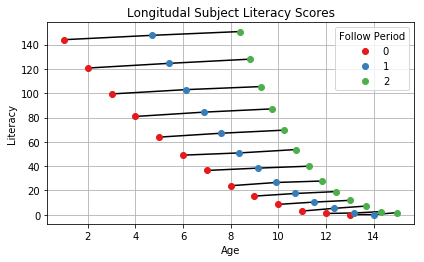

In [2]:
computer_data = pd.read_csv('./computer-data-hw1.csv')

fig = plt.figure(figsize=(6, 3.75))
ax = fig.gca()
ax.grid(True)

for i, subject in enumerate(computer_data['subj'].unique()):
    sub_data = computer_data[computer_data['subj'] == subject]
    ax.plot(sub_data['total.age'], sub_data['literacy'].values, '-k')

for i, follow_per in enumerate(computer_data['follow.per'].unique()):
    sub_data = computer_data[computer_data['follow.per'] == follow_per]
    ax.plot(sub_data['total.age'], sub_data['literacy'],
            'o', color=plt.cm.Set1(i), label='{}'.format(follow_per))
    
ax.set_xlabel('Age')
ax.set_ylabel('Literacy')
ax.set_title('Longitudal Subject Literacy Scores')
ax.legend(title='Follow Period')
fig.tight_layout()
fig.savefig('p3_data.pdf', bbox_inches='tight')

computer_data.head(n=10)
computer_data[computer_data['follow.per'] == 1].describe()

In [3]:
def fit_ols(X, y):
    gram_matrix = X.T.dot(X)
    gram_matrix_inv = linalg.cho_solve(linalg.cho_factor(gram_matrix), np.eye(len(gram_matrix)))    
    beta_hat = gram_matrix_inv.dot(X.T).dot(y)
    sigma_2_hat = np.sum(np.square(y - X.dot(beta_hat)))/(len(y) - len(beta_hat))
    return beta_hat, gram_matrix_inv*sigma_2_hat, sigma_2_hat

In [4]:
def fit_original(data):
    X = np.column_stack((np.ones(len(data)), data[['base.age', 'delta.age']].values))
    y = data['literacy'].values
    return fit_ols(X, y)

fit_original(computer_data)

(array([133.02690855, -11.9680251 ,   1.24721578]),
 array([[35.38965932, -3.08971504, -4.28560487],
        [-3.08971504,  0.36085295,  0.25406082],
        [-4.28560487,  0.25406082,  1.12990206]]),
 165.83485669258215)

In [5]:
def fit_alternative(data):
    sub_data = data[data['follow.per'] == 0][['subj', 'literacy']]
    sub_data = pd.merge(data, sub_data.rename(columns={'literacy': 'base.literacy'}))
    sub_data = sub_data[sub_data['follow.per'] != 0]
    X = sub_data[['delta.age']].values
    y = sub_data['literacy'].values - sub_data['base.literacy'].values
    return fit_ols(X, y)

fit_alternative(computer_data)

(array([1.02185154]), array([[0.00105099]]), 0.3850802073163594)

## Simulations

In [6]:
def make_covariates(n):
    X = []
    for i in range(n):
        base_age = stats.uniform.rvs(0, 15)
        X.append([i, base_age, 0, 0])
        
        for j in range(2):
            delta_age = stats.norm.rvs(3 + j*3, scale=0.5)
            X.append([i, base_age, delta_age, j + 1])
            
    return pd.DataFrame(X, columns=['subj', 'base.age', 'delta.age', 'follow.per'])

def make_independent_covariates(n):    
    subj = {}
    X = []
    for i in range(n):
        base_age = stats.uniform.rvs(0, 15)
        X.append([i, base_age, 0, 0])
        subj[i] = {'follow_per': 0, 'base_age': base_age}
        
    for j in range(n*2):
        i = stats.randint.rvs(low=0, high=n)
        subj[i]['follow_per'] += 1
        X.append([i, subj[i]['base_age'], stats.uniform.rvs(0, 10), subj[i]['follow_per']])
    
    return pd.DataFrame(X, columns=['subj', 'base.age', 'delta.age', 'follow.per'])

def make_response(data, f):
    data = data.copy()
    data['literacy'] = stats.norm.rvs(f(data['base.age']) + 2*data['delta.age'], scale=1)
    return data

In [7]:
np.random.seed(2020)
simulated_data = make_covariates(64)

### Both Assumptions Violated

In [8]:
beta_hat_original_estimates = []
beta_hat_alternative_estimates = []

for i in range(100):
    response_data = make_response(simulated_data, lambda x: 200*np.exp(-x))
    beta_hat, beta_hat_variance, sigma_2_hat = fit_original(response_data)
    beta_hat_original_estimates.append(beta_hat)
    
    beta_hat, beta_hat_variance, sigma_2_hat = fit_alternative(response_data)
    beta_hat_alternative_estimates.append(beta_hat)

    
np.mean(beta_hat_original_estimates, 0), np.mean(beta_hat_alternative_estimates, 0)

(array([31.96619861, -3.20229314,  2.16353098]), array([2.00158068]))

### Linear $f$ but Dependent Covariates

Only the Part (b) condition is now violated.

In [9]:
beta_hat_original_estimates = []
beta_hat_alternative_estimates = []

for i in range(100):
    response_data = make_response(simulated_data, lambda x: 200 - 12*x)
    beta_hat, beta_hat_variance, sigma_2_hat = fit_original(response_data)
    beta_hat_original_estimates.append(beta_hat)
    
    beta_hat, beta_hat_variance, sigma_2_hat = fit_alternative(response_data)
    beta_hat_alternative_estimates.append(beta_hat)

    
np.mean(beta_hat_original_estimates, 0), np.mean(beta_hat_alternative_estimates, 0)

(array([200.00853446, -11.9993114 ,   1.99779186]), array([1.99509547]))

### Non-linear $f$ but Independent Covariates

Only the Part (a) condition is violated now.

In [10]:
beta_hat_original_estimates = []
beta_hat_alternative_estimates = []

np.random.seed(2019)
for i in range(1024):
    simulated_data = make_independent_covariates(64)
    response_data = make_response(simulated_data, lambda x: 200*np.exp(-x))
    beta_hat, beta_hat_variance, sigma_2_hat = fit_original(response_data)
    beta_hat_original_estimates.append(beta_hat)
    
    beta_hat, beta_hat_variance, sigma_2_hat = fit_alternative(response_data)
    beta_hat_alternative_estimates.append(beta_hat)
    
np.mean(beta_hat_original_estimates, 0), np.mean(beta_hat_alternative_estimates, 0)

(array([47.92338712, -4.63105486,  1.99852915]), array([2.00052851]))

### Standard Error Simulations

In [11]:
beta_hat_estimates = []
beta_hat_l_variances = []
is_covered = []
is_covered_sandwich = []

np.random.seed(2019)
for i in range(2048):
    simulated_data = make_independent_covariates(64)
    response_data = make_response(simulated_data, lambda x: 200*np.exp(-x))
    beta_hat, beta_hat_variance, sigma_2_hat = fit_original(response_data)
    
    X = np.column_stack((np.ones(len(response_data)), response_data[['base.age', 'delta.age']].values))
    y = response_data['literacy']
    
    gram_inverse = beta_hat_variance/sigma_2_hat
    sandwich_variance = X.T.dot(np.diag(np.square(y - X.dot(beta_hat)))).dot(X)
    sandwich_variance = gram_inverse.dot(sandwich_variance).dot(gram_inverse)
    
    beta_hat_estimates.append(beta_hat)
    beta_hat_l_variances.append(beta_hat_variance[2,2])    
    is_covered.append(np.abs(beta_hat[2] - 2) <= stats.norm.ppf(0.975)*np.sqrt(beta_hat_variance[2,2]))
    is_covered_sandwich.append(np.abs(beta_hat[2] - 2) <= stats.norm.ppf(0.975)*np.sqrt(sandwich_variance[2,2]))
        
np.sum(is_covered)/len(is_covered), np.sum(is_covered_sandwich)/len(is_covered_sandwich)

(0.98095703125, 0.9775390625)